<a href="https://colab.research.google.com/github/shyam97/cmf/blob/Checkpoint-Gamma/smagorinsky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Header Files

In [0]:
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
%matplotlib inline
import time
start = time.time()
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Grid Settings

In [0]:
l = 0.05
w = 0.005
nx = 20
ny = 20
h_x = l/nx
h_y = w/ny
md = 0

xx,yy=np.mgrid[0:l-h_x:nx*1j,0:w-h_y:ny*1j]

x = np.linspace(0.,l,nx)
y = np.linspace(0.,w,ny)

### Time Step Settings

In [0]:
dt = 1e-4
tsteps = 100
flow = dt*tsteps
clock = 0

### Iteration Settings

In [0]:
maxiter = 1000
maxerror = 1e-10
beta = 1.2 #Over-relaxation parameter
iter = 0

### Static Parameters

In [0]:
rho_s = 1.25
rho_w = 1e10
mu_s = 1e-5
p_s = 0
gx = 0
gy = 0

###  Initializing Matrices

In [0]:
# defined using length of the interval and not number of grid points
u = np.zeros((nx+2,ny+2)) #Having an extra set of rows at the outlet for having ghost cells to implement boundary conditions
v = np.zeros((nx+2,ny+1))
p = np.zeros((nx+2,ny+2)) + p_s

# INTERMEDIATE VELOCITIES
ustar = u.copy()
vstar = v.copy()

# COEFFICIENTS FOR PRESSURE
p1 = p.copy()
p2 = p.copy()

# DENSITY AND VISCOSITY MATRIX
rho = np.ones((nx+2,ny+2))*rho_s
mu = np.ones((nx+2,ny+2))*mu_s

### Static Boundary Conditions

In [0]:
# INLET STATIC BOUNDARY
u[0,:] = 0
p[0,:] = 1

# OUTLET STATIC BOUNDARY
p[-1,:] = 0

# BOTTOM WALL STATIC BOUNDARY
v[:,0] = 0
# p[:,0] = 0

# TOP WALL STATIC BOUNDARY
v[:,-1] = 0
p[:,-1] = 0

### Time Integration and Solution

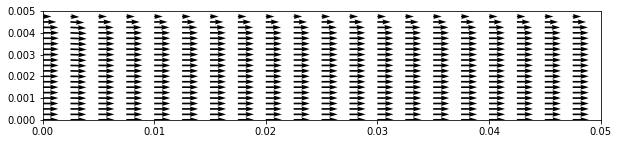

0.01 289.905 2.629e-07 Not converged


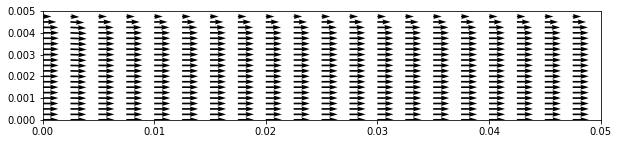

In [0]:
for t in range(0,tsteps):
    clock = clock + dt

    # INLET DYNAMIC BOUNDARY
    v[0,:] = -1*v[1,:]
    p[:,0] = p[:,1] #Axisymmetric boundary condition

    # OUTLET DYNAMIC BOUNDARY
    v[-1,:] = 1*v[-2,:]
    u[-1,:] = u[-2,:]

    # BOTTOM WALL DYNAMIC BOUNDARY
    u[:,0] = +1*u[:,1] #For axisymmetric flows this condition is valid, but u[:,0] = -1*u[:,1] for 2D channel flow

    # TOP WALL DYNAMIC BOUNDARY
    u[:,-1] = -1*u[:,-2]

    # U STAR
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            #Advection terms - x component
            Ax = ((u[i+1,j] + u[i,j])**2 - (u[i,j]+u[i-1,j])**2)/(4*h_x) +\
                 ((u[i,j+1] + u[i,j])*(v[i+1,j] + v[i,j]) - (u[i,j] + u[i,j-1])*\
                   (v[i+1,j-1] + v[i,j-1]))/(4*h_y)

            #Diffusion terms - x component
            Dx = 0.5*(mu[i+1,j] + mu[i,j])*\
                ((u[i+1,j] -2*u[i,j] + u[i-1,j])/(h_x**2) +\
                 (u[i,j+1] -2*u[i,j] + u[i,j-1])/(h_y**2))

            #Predictor step - x component
            ustar[i,j] = u[i,j] + dt*(-Ax + (2/(rho[i,j] + rho[i+1,j]))*Dx + gx)


    #V STAR
    for i in range(1,nx+1):
        for j in range(1,ny):
            #Advection terms - y component
            Ay = ((u[i,j+1] + u[i,j])*(v[i,j] + v[i+1,j]) - (u[i-1,j+1] + u[i-1,j])*\
                  (v[i,j] + v[i-1,j]))/(4*h_x) + ((v[i,j+1] + v[i,j])**2 -\
                  (v[i,j] + v[i,j-1])**2)/(4*h_y)

            #Diffusion terms - y component
            Dy = 0.5*(mu[i,j+1] + mu[i,j])*\
                ((v[i+1,j] - 2*v[i,j] + v[i-1,j])/(h_x**2) +\
                 (v[i,j+1] - 2*v[i,j] + v[i,j-1])/(h_y**2))

            #Predictor step - y component
            vstar[i,j] = v[i,j] + dt*(-Ay + gy + 2*Dy/((rho[i,j+1] + rho[i,j])))

    rt=rho.copy()
    rt[:,0] = rho_w
    rt[:,-1] = rho_w

    for i in range(1,nx+1):
        for j in range(1,ny+1):
            p1[i,j]= (0.5/dt)*( (ustar[i,j]-ustar[i-1,j])/h_x+(vstar[i,j]-vstar[i,j-1])/h_y)
            p2[i,j]=1.0/( (1./h_x)*( 1./(h_x*(rt[i+1,j]+rt[i,j]))+\
                1./(h_x*(rt[i-1,j]+rt[i,j])))+\
                (1./h_y)*(1./(h_y*(rt[i,j+1]+rt[i,j]))+\
                1./(h_y*(rt[i,j-1]+rt[i,j]))))

    iter=0
    while True:
        # p[0,:] = p[1,:]
        pn=p.copy()
        iter=iter+1
        for i in range(1,nx+1):
            for j in range(1,ny+1):
                p[i,j]=(1.0-beta)*p[i,j]+beta*p2[i,j]*(\
                    (1./h_x)*( p[i+1,j]/(h_x*(rt[i+1,j]+rt[i,j]))+\
                    p[i-1,j]/(h_x*(rt[i-1,j]+rt[i,j])))+\
                    (1./h_y)*( p[i,j+1]/(h_y*(rt[i,j+1]+rt[i,j]))+\
                    p[i,j-1]/(h_y*(rt[i,j-1]+rt[i,j])))-p1[i,j])

        # print(np.abs(pn-p).max())
        if np.abs(pn-p).max()<maxerror:
            converged = "Converged"
            break
        if iter>maxiter:
            converged = "Not converged"
            break
    
    #IMPLEMENTING THE TURBULENCE MODEL (SMAGORINSKY)
    nu_t = np.zeros((nx+2,ny+2)) #Defining the turbulence eddy viscosity
        for i in range(1,nx+1):
          for j in range(1,ny+1):
            term1_smag = (u[i+1,j] - u[i,j])/h_x
            term2_smag = (v[i,j+1] - v[i,j])/h_y
            term3_smag = 0.5*((u[i,j+1] - u[i,j-1])/(2*h_y)) + (u[i+1,j+1]) - u[i+1,j-1]/(2*h_y)) + 0.5*((v[i+1,j] - v[i-1,j])/(2*h_x)) + (v[i+1,j+1]) - v[i-1,j+1]/(2*h_x))
            #Check velocity and pressure grids to confirm the above terms if required
            nu_t[i,j] = h_x*h_y*np.sqrt(term1_smag^2 + term2_smag^2 + 0.5*(term3_smag)^2)
            mu = mu_s + nu_t[i,j]*rho[i,j]

    
    #CORRECT THE u-velocity
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            u[i,j]=ustar[i,j]-dt*(2.0/h_x)*(p[i+1,j]-p[i,j])/(rho[i+1,j]+rho[i,j])

    #CORRECT THE v-velocity
    for i in range(1,nx+1):
        for j in range(1,ny):
            v[i,j]=vstar[i,j]-dt*(2.0/h_y)*(p[i,j+1]-p[i,j])/(rho[i,j+1]+rho[i,j])

    #SET PRESSURE AT THE INLET TO BE FIXED
    u[0,:] = u[1,:]
    
    uu=0.5*(u[0:nx,1:ny+1]+u[0:nx,0:ny])
    vv=0.5*(v[1:nx+1,0:ny]+v[0:nx,0:ny])

    plt.figure(num=1, figsize = (10,2))
    plt.clf()
    plt.quiver(xx.T,yy.T,2*uu.T,2*vv.T)
    # plt.streamplot(x,y,uu.T,vv.T)
    plt.xlim([0,l])
    plt.ylim([0,w])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    # ax = plt.gca()
    # im = ax.imshow(u.T, origin = 'lower', extent=[-h_x,l+h_x,-h_y,w+h_y])
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(im, cax=cax)
    # plt.pause(0.001)

    print(np.round(clock,4), np.round(time.time() - start,3), np.round(np.abs(pn-p).max(),10),converged)

### Final Plots

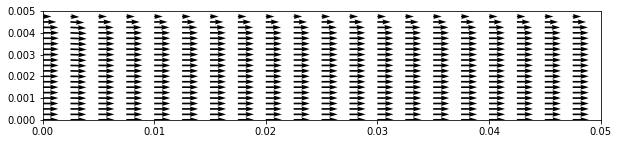

In [0]:
plt.figure(num=1, figsize = (10,2))
plt.clf()
plt.quiver(xx.T,yy.T,2*uu.T,2*vv.T)
plt.xlim([0,l])
plt.ylim([0,w])
plt.show()

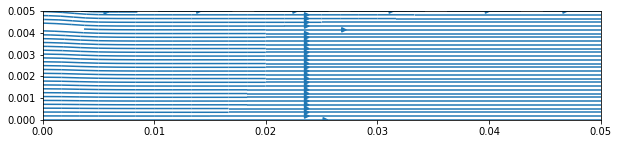

In [0]:
plt.figure(num=2, figsize = (10,2))
plt.clf()
plt.streamplot(x,y,uu.T,vv.T);
plt.xlim([0,l])
plt.ylim([0,w])
plt.show()

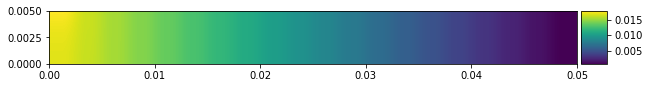

In [0]:
plt.figure(num=3, figsize=(10,2))
plt.clf()
ax = plt.gca()
im = ax.imshow(p[1:nx+1,1:ny+1].T, origin = 'lower', extent=[0,l,0,w])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
plt.show()